
# Probabilistic Principal Component Analysis (PPCA) on Digits Dataset

This code implements PPCA by two methods:
1. ML solution using spectral decomposition.
2. EM algorithm for PPCA.

The data is loaded from the digits dataset in sklearn, and we perform dimensionality reduction and projection on the training set.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh, inv
from sklearn.datasets import load_digits
from sklearn.manifold import TSNE
# Set display configuration
%config InlineBackend.figure_format = "retina"
np.set_printoptions(precision=4, suppress=True)


## Data Loading
Load the digits dataset.


In [13]:
digits = load_digits()
X = digits.data      # Each sample is 64-dimensional (8x8 image)
y = digits.target
print("X shape:", X.shape)
print("Unique labels:", np.unique(y))

Xtrain = X
ytrain = y
N, D = Xtrain.shape
print("Train set shape:", Xtrain.shape)
print(y.shape)


print(np.unique(y))

X shape: (1797, 64)
Unique labels: [0 1 2 3 4 5 6 7 8 9]
Train set shape: (1797, 64)
(1797,)
[0 1 2 3 4 5 6 7 8 9]


In [3]:
# This function is used to visualize the digits.  No need to fully understand it
# I just want to show you the data
def visualize_digits(X, y, n_samples=10, random_state=42):
    """
    Visualize random digit samples from the dataset

    Parameters:
    -----------
    X : array-like of shape (n_samples, 64)
        The digit image data (flattened 8x8 images)
    y : array-like of shape (n_samples,)
        The labels
    n_samples : int
        Number of samples to visualize
    random_state : int
        Random seed for reproducibility
    """
    # Set random seed
    np.random.seed(random_state)

    # Randomly select indices
    indices = np.random.choice(len(X), n_samples, replace=False)

    # Create subplot grid
    n_cols = 5
    n_rows = (n_samples + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(2*n_cols, 2*n_rows))

    # Flatten axes for easier iteration
    axes = axes.ravel()

    # Plot each digit
    for idx, ax in enumerate(axes):
        if idx < n_samples:
            # Reshape the flattened image back to 8x8
            digit_image = X[indices[idx]].reshape(8, 8)

            # Plot the image
            ax.imshow(digit_image, cmap='gray')
            ax.set_title(f'Label: {y[indices[idx]]}')

        # Remove ticks
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.show()

We visualize 15 samples from X and corresponding label y.

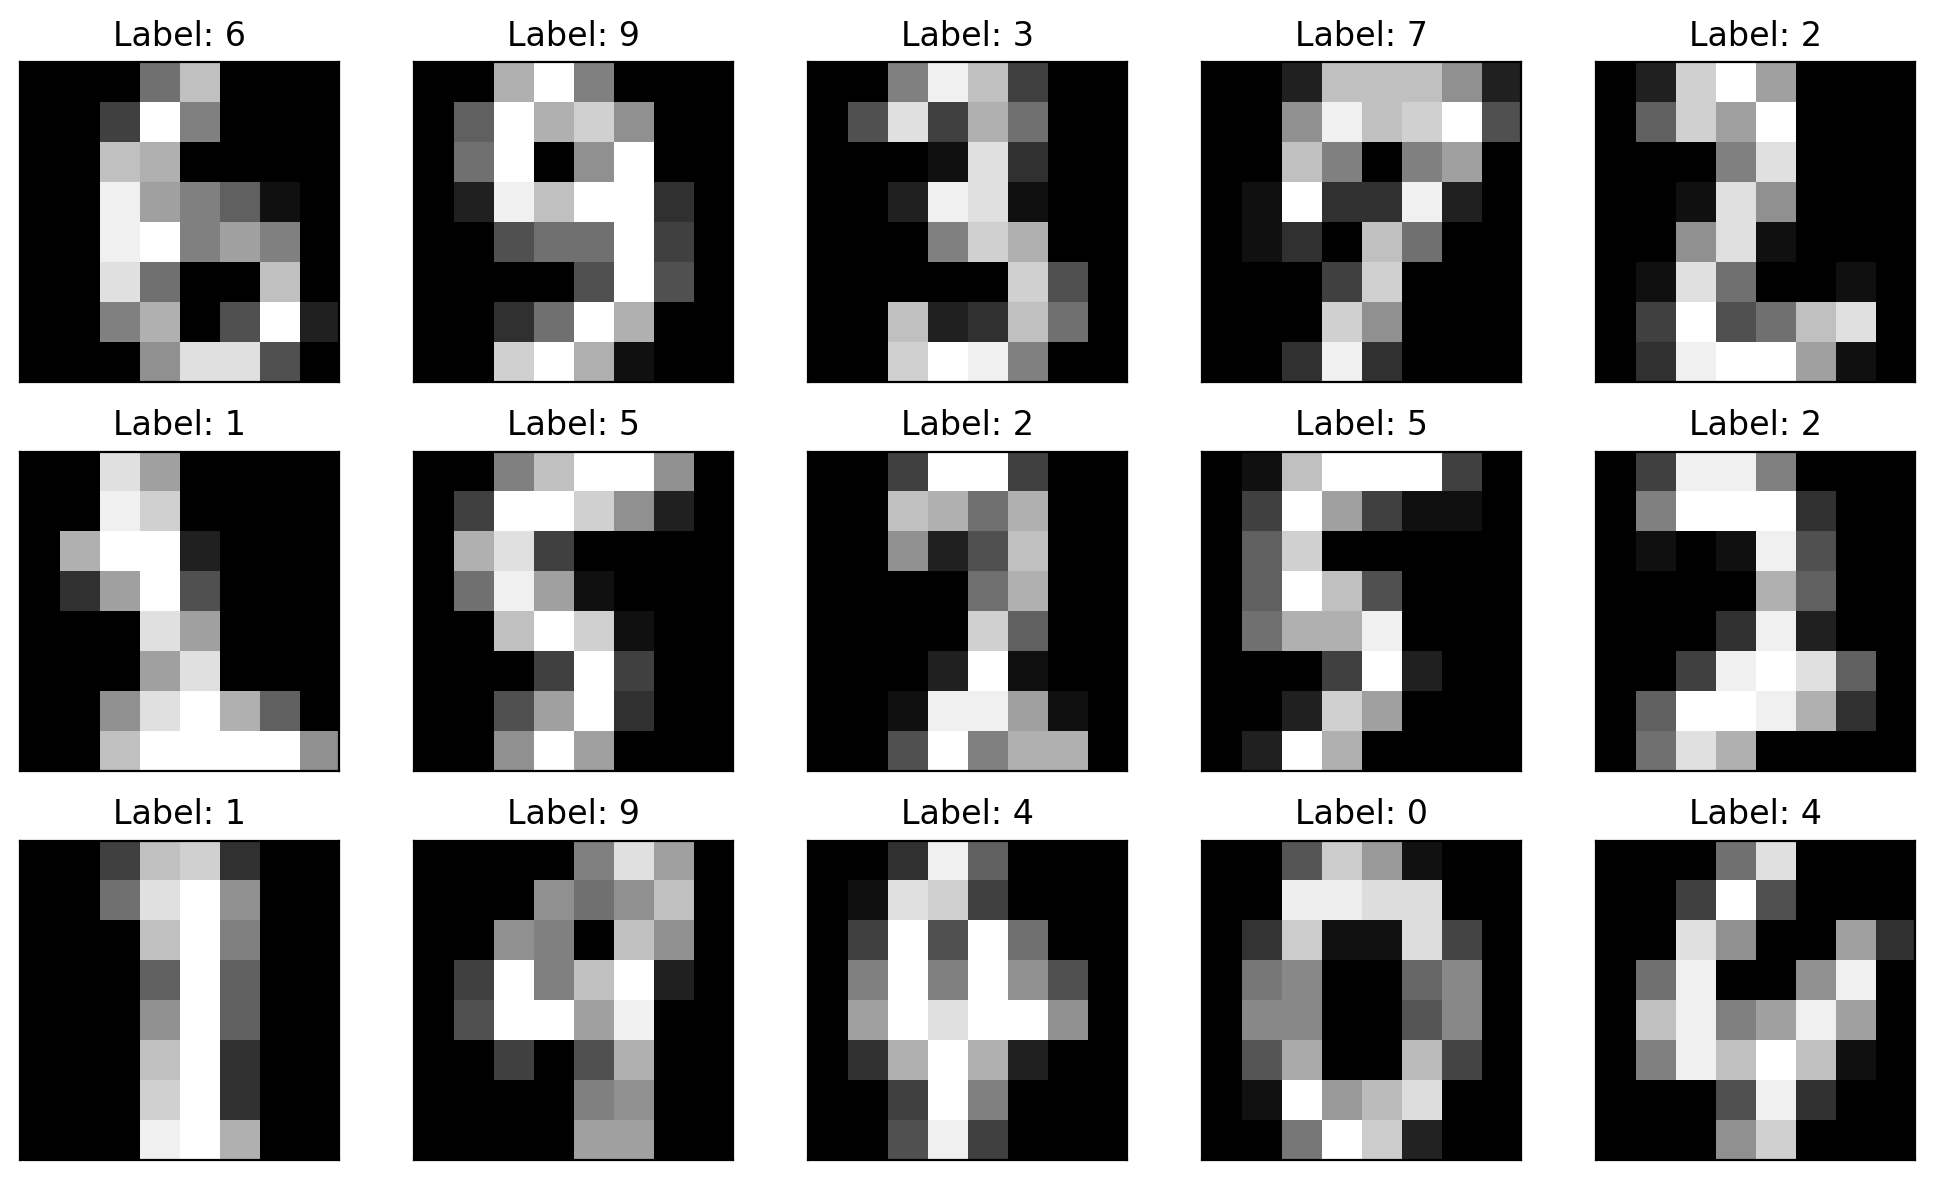

In [4]:
visualize_digits(X, y, n_samples=15)


## ML PPCA
Compute ML estimates using spectral decomposition and project the data to a lower-dimensional space.




eigenvalues.shape (64,)
eigenvector.shape (64, 64)
W_ML.shape (64, 2)
Z.shape (1797, 2)


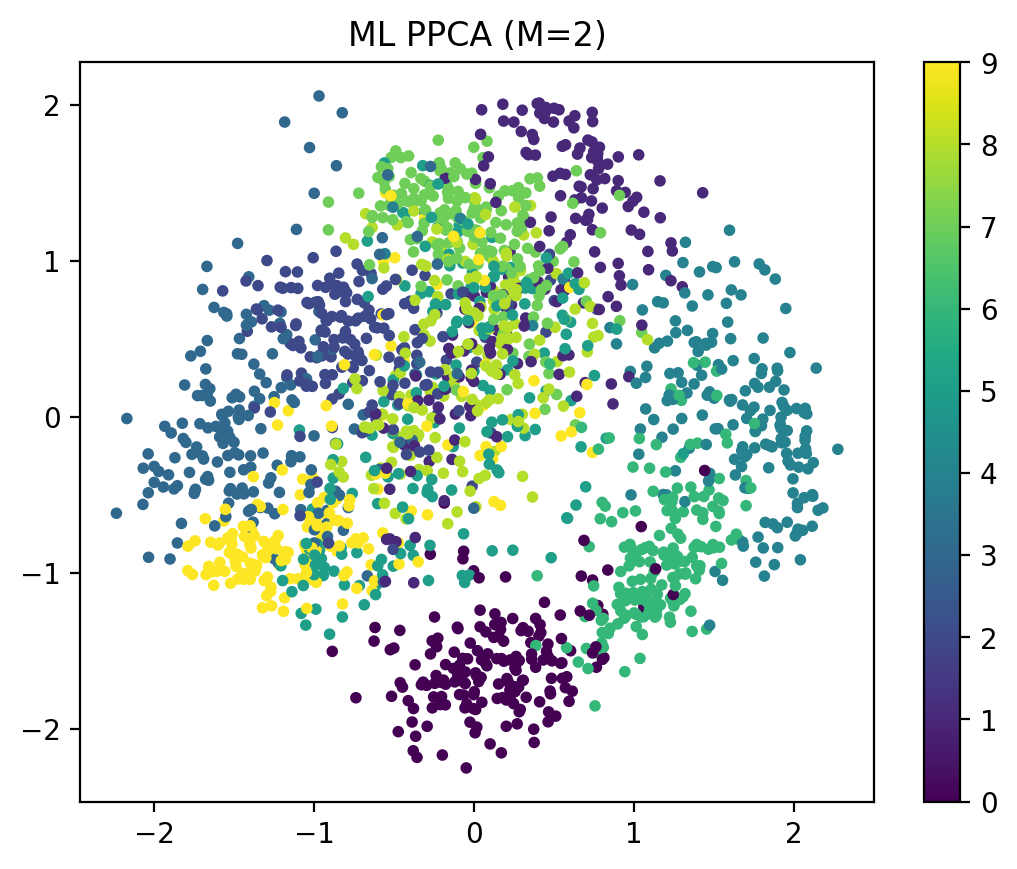

In [14]:
import matplotlib.pyplot as plt
M = 2 #latent dim

# (a) Compute the sample mean and sample covariance of the entire dataset
mu_ML = np.mean(Xtrain, axis=0)
cov_ML=np.cov(Xtrain,rowvar=False)
Xc= Xtrain-mu_ML

# (b) Perform spectral decomposition of the sample covariance matrix
eigenvalues,eigenvector = np.linalg.eigh(cov_ML)
idx= np.argsort(eigenvalues)[::-1]
eigenvalues=eigenvalues[idx]
eigenvector= eigenvector[:,idx]

print("eigenvalues.shape",eigenvalues.shape)
print("eigenvector.shape",eigenvector.shape)

# (c) Compute sigma^2_ML and W_ML
U_M = eigenvector[:,:M]
top_eigenvalues = eigenvalues[:M]
sigma2_ML = np.mean(eigenvalues[M:])
L_M = np.diag(top_eigenvalues)
W_ML = U_M @ np.sqrt(L_M - sigma2_ML * np.eye(M))
print("W_ML.shape",W_ML.shape )

# (d) Compute the posterior projection E[z | x] using the entire dataset.
Mmat= W_ML.T@W_ML+ sigma2_ML *np.eye(M)
Z= np.linalg.solve(Mmat,W_ML.T@Xc.T).T
print("Z.shape",Z.shape)

# (e) Plot the resulting 2D projection
plt.figure()
sc=plt.scatter(Z[:,0],Z[:,1],c=y,s=10)
plt.colorbar(sc)
plt.title("ML PPCA (M=2)")
plt.show()




## EM Algorithm Implementation for PPCA




## Task4

The following code show example how to using standard PCA extract the latent embeddings and project the latent embeddings using t-SNE.

In [ ]:
import time
from sklearn.decomposition import PCA

def run_pca_once(X, n_comp):
    """
    Run PCA once and return running time and results
    """
    start_time = time.time()
    pca = PCA(n_components=n_comp)
    Z = pca.fit_transform(X)
    end_time = time.time()
    return end_time - start_time, pca, Z

def compare_svd_pca_components(X, y, components_list=[2, 5, 10, 20], n_runs=3):
    """
    Compare PCA results with different numbers of components using SVD

    Parameters:
    -----------
    X : array-like
        Input data
    y : array-like
        Labels for coloring
    components_list : list
        List of n_components to try
    n_runs : int
        Number of times to run each PCA for timing
    """
    # Create subplot grid with 5 plots per row
    n_plots = len(components_list)
    n_cols = 5
    n_rows = (n_plots + n_cols - 1) // n_cols
    fig = plt.figure(figsize=(20, 4*n_rows))
    gs = plt.GridSpec(n_rows, n_cols+1, width_ratios=[1]*n_cols + [0.05])

    # Initialize t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)

    # Record running times
    running_times = []
    running_times_std = []  # Standard deviation of running times
    #Record variance explained
    var_explaineds = []

    # Create axes for plots
    axes = []
    for i in range(n_plots):
        row = i // n_cols
        col = i % n_cols
        axes.append(plt.subplot(gs[row, col]))

    for idx, (ax, n_comp) in enumerate(zip(axes, components_list)):
        # Run PCA multiple times
        times = []
        for _ in range(n_runs):
            time_taken, pca, Z = run_pca_once(X, n_comp)
            times.append(time_taken)

        # Calculate mean and std of running times
        mean_time = np.mean(times)
        std_time = np.std(times)
        running_times.append(mean_time)
        running_times_std.append(std_time)

        # Use last PCA result for visualization
        if n_comp > 2:
            Z_2d = tsne.fit_transform(Z)
        else:
            Z_2d = Z

        # Plot
        scatter = ax.scatter(Z_2d[:, 0], Z_2d[:, 1], c=y, cmap='tab10', s=10)
        explained_var = np.sum(pca.explained_variance_ratio_) * 100
        var_explaineds.append(explained_var)
        ax.set_title(f'Standard-PCA (n={n_comp})\nVar: {explained_var:.1f}%\nTime: {mean_time:.3f}±{std_time:.3f}s')
        ax.set_xlabel('Component 1')
        ax.set_ylabel('Component 2')

    # Add colorbar in a separate axis
    cbar_ax = plt.subplot(gs[:, -1])
    plt.colorbar(scatter, cax=cbar_ax)

    plt.tight_layout()
    plt.show()

    # Print detailed results
    print("\nDetailed results:")
    print(f"{'n_components':<12} {'Time (s)':<15} {'Std Dev':<10} {'Variance Explained':<20}")
    print("-" * 57)
    for n_comp, mean_time, std_time, var_explained in zip(components_list, running_times, running_times_std, var_explaineds):

        print(f"{n_comp:<12} {mean_time:<15.3f} {std_time:<10.3f} {var_explained:<20.2f}%")

    # Plot running times with error bars
    plt.figure(figsize=(10, 5))
    plt.errorbar(components_list, running_times, yerr=running_times_std,
                fmt='o-', linewidth=2, markersize=8, capsize=5)
    plt.xlabel('Number of Components')
    plt.ylabel('Running Time (seconds)')
    plt.title(f'PCA Running Time vs Number of Components\n(Average of {n_runs} runs with std dev)')
    plt.grid(True)
    plt.show()

In [ ]:

components_to_try = [2,  5,  7, 10, 13, 15, 17, 20, 30, 40,]
compare_svd_pca_components(X, y, components_to_try, n_runs=3)

### ML PPCA

In the following part, your just need to using your implementation of ML PPCA to extract the latent embedding Z in function `run_mlppca_once`

In [ ]:
def run_mlppca_once(X, n_comp):
    """
    Run ML-PPCA once and return running time and results

    Parameters:
    -----------
    X : array-like
        Input data
    n_comp : int
        Number of components

    Returns:
    --------
    time_taken : float
        Running time in seconds
    Z : array-like
        Transformed data
    """
    start_time = time.time()
    # write your code here to get the latent embeddings Z using your own implementation of ML-PPCA
    # some code here
    # Z=
    end_time = time.time()
    return end_time - start_time, Z

def compare_mlpca_components(X, y, components_list=[2, 5, 10, 20], n_runs=3):
    """
    Compare ML-PPCA results with different numbers of components

    Parameters:
    -----------
    X : array-like
        Input data
    y : array-like
        Labels for coloring
    components_list : list
        List of n_components to try
    n_runs : int
        Number of times to run each PPCA for timing
    """
    # Create subplot grid with 5 plots per row
    n_plots = len(components_list)
    n_cols = 5
    n_rows = (n_plots + n_cols - 1) // n_cols
    fig = plt.figure(figsize=(20, 4*n_rows))
    gs = plt.GridSpec(n_rows, n_cols+1, width_ratios=[1]*n_cols + [0.05])

    # Initialize t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)

    # Record running times
    running_times = []
    running_times_std = []  # Standard deviation of running times

    # Create axes for plots
    axes = []
    for i in range(n_plots):
        row = i // n_cols
        col = i % n_cols
        axes.append(plt.subplot(gs[row, col]))

    for idx, (ax, n_comp) in enumerate(zip(axes, components_list)):
        # Run ML-PPCA multiple times
        times = []
        for _ in range(n_runs):
            time_taken, Z = run_mlppca_once(X, n_comp)
            times.append(time_taken)

        # Calculate mean and std of running times
        mean_time = np.mean(times)
        std_time = np.std(times)
        running_times.append(mean_time)
        running_times_std.append(std_time)

        # Use last PPCA result for visualization
        if n_comp > 2:
            Z_2d = tsne.fit_transform(Z)
        else:
            Z_2d = Z

        # Plot
        scatter = ax.scatter(Z_2d[:, 0], Z_2d[:, 1], c=y, cmap='tab10', s=10)
        ax.set_title(f'ML-PPCA (n={n_comp})\nTime: {mean_time:.3f}±{std_time:.3f}s')
        ax.set_xlabel('Component 1')
        ax.set_ylabel('Component 2')

    # Add colorbar in a separate axis
    cbar_ax = plt.subplot(gs[:, -1])
    plt.colorbar(scatter, cax=cbar_ax)

    plt.tight_layout()
    plt.show()

    # Print detailed results
    print("\nDetailed results:")
    print(f"{'n_components':<12} {'Time (s)':<15} {'Std Dev':<10}")
    print("-" * 37)
    for n_comp, mean_time, std_time in zip(components_list, running_times, running_times_std):
        print(f"{n_comp:<12} {mean_time:<15.3f} {std_time:<10.3f}")

    # Plot running times with error bars
    plt.figure(figsize=(10, 5))
    plt.errorbar(components_list, running_times, yerr=running_times_std,
                fmt='o-', linewidth=2, markersize=8, capsize=5)
    plt.xlabel('Number of Components')
    plt.ylabel('Running Time (seconds)')
    plt.title(f'ML-PPCA Running Time vs Number of Components\n(Average of {n_runs} runs with std dev)')
    plt.grid(True)
    plt.show()

components_to_try = [2, 5, 7, 10, 13, 15, 17, 20, 30, 40]
# set n_runs to 1 for debugging; set n_runs to 3 for final submission
compare_mlpca_components(X, y, components_to_try, n_runs=1)

### EM PPCA

In the following code, you just need to use your implement of EM PPCA to extract the latent embedding Z and record the log-likelihood values during iterations in function `run_ppca_em_once`

In [ ]:
def run_ppca_em_once(X, n_comp, n_iter=30, seed=None):
    """
    Run PPCA EM algorithm once and return running time and results

    Parameters:
    -----------
    X : array-like
        Input data
    n_comp : int
        Number of components
    n_iter : int
        Number of EM iterations
    seed : int
        Random seed for initialization

    Returns:
    --------
    time_taken : float
        Running time in seconds
    Z : array-like
        Transformed data
    Q_history : list
        History of log-likelihood values
    """
    start_time = time.time()

    # Initialize PPCA and Run EM iterations
    # some code here
    # Z=
    # Q_history=



    end_time = time.time()
    return end_time - start_time, Z, Q_history

def compare_ppca_em_components(X, y, components_list=[2, 5, 10, 20], n_runs=3, n_iter=30):
    """
    Compare PPCA EM results with different numbers of components

    Parameters:
    -----------
    X : array-like
        Input data
    y : array-like
        Labels for coloring
    components_list : list
        List of n_components to try
    n_runs : int
        Number of times to run each PPCA for timing
    n_iter : int
        Maximum number of EM iterations
    """
    # Create subplot grid with 5 plots per row
    n_plots = len(components_list)
    n_cols = 5
    n_rows = (n_plots + n_cols - 1) // n_cols
    fig = plt.figure(figsize=(20, 4*n_rows))
    gs = plt.GridSpec(n_rows, n_cols+1, width_ratios=[1]*n_cols + [0.05])

    # Initialize t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)

    # Record running times and convergence iterations
    running_times = []
    running_times_std = []
    convergence_iters = []
    convergence_iters_std = []

    # Create axes for plots
    axes = []
    for i in range(n_plots):
        row = i // n_cols
        col = i % n_cols
        axes.append(plt.subplot(gs[row, col]))

    for idx, (ax, n_comp) in enumerate(zip(axes, components_list)):
        # Run PPCA EM multiple times
        times = []
        iters = []
        for run in range(n_runs):
            time_taken, Z, Q_history = run_ppca_em_once(X, n_comp, n_iter, seed=42+run)
            times.append(time_taken)
            iters.append(len(Q_history)-1)  # -1 because Q_history includes initial value

        # Calculate statistics
        mean_time = np.mean(times)
        std_time = np.std(times)
        mean_iters = np.mean(iters)
        std_iters = np.std(iters)

        running_times.append(mean_time)
        running_times_std.append(std_time)
        convergence_iters.append(mean_iters)
        convergence_iters_std.append(std_iters)

        # Use last PPCA result for visualization
        if n_comp > 2:
            Z_2d = tsne.fit_transform(Z)
        else:
            Z_2d = Z

        # Plot
        scatter = ax.scatter(Z_2d[:, 0], Z_2d[:, 1], c=y, cmap='tab10', s=10)
        ax.set_title(f'PPCA EM (n={n_comp})\nTime: {mean_time:.3f}±{std_time:.3f}s\nIters: {mean_iters:.1f}±{std_iters:.1f}')
        ax.set_xlabel('Component 1')
        ax.set_ylabel('Component 2')

    # Add colorbar in a separate axis
    cbar_ax = plt.subplot(gs[:, -1])
    plt.colorbar(scatter, cax=cbar_ax)

    plt.tight_layout()
    plt.show()

    # Print detailed results
    print("\nDetailed results:")
    print(f"{'n_components':<12} {'Time (s)':<15} {'Std Dev':<10} {'Iterations':<15} {'Iter Std Dev':<10}")
    print("-" * 62)
    for n_comp, mean_time, std_time, mean_iter, std_iter in zip(
        components_list, running_times, running_times_std, convergence_iters, convergence_iters_std):
        print(f"{n_comp:<12} {mean_time:<15.3f} {std_time:<10.3f} {mean_iter:<15.1f} {std_iter:<10.1f}")

    # Plot running times with error bars
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Time plot
    ax1.errorbar(components_list, running_times, yerr=running_times_std,
                fmt='o-', linewidth=2, markersize=8, capsize=5)
    ax1.set_xlabel('Number of Components')
    ax1.set_ylabel('Running Time (seconds)')
    ax1.set_title(f'PPCA EM Running Time\n(Average of {n_runs} runs with std dev)')
    ax1.grid(True)

    # Iterations plot
    ax2.errorbar(components_list, convergence_iters, yerr=convergence_iters_std,
                fmt='o-', linewidth=2, markersize=8, capsize=5)
    ax2.set_xlabel('Number of Components')
    ax2.set_ylabel('Number of Iterations')
    ax2.set_title(f'PPCA EM Convergence Iterations\n(Average of {n_runs} runs with std dev)')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


components_to_try = [2, 5, 7, 10, 13, 15, 17, 20, 30, 40]
# set n_runs to 1 for debugging; set n_runs to 3 for final submission
compare_ppca_em_components(X, y, components_to_try, n_runs=1, n_iter=50)